# Transformer 기반 Time Series Forecasting (using PyTorch Lightning)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
# ✅ 데이터 로드 및 시간 순서 기반 Split
df = pd.read_csv('서인천IC-부평IC 평균속도.csv', encoding='CP949')
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# Scaling (train에서만 fit, val/test는 transform)
scaler = MinMaxScaler() # outlier가 있으면 사용 x -> Robust(강인한), 0 - 1 사이
train_df['평균속도'] = scaler.fit_transform(train_df['평균속도'].values.reshape(-1, 1))
val_df['평균속도'] = scaler.transform(val_df['평균속도'].values.reshape(-1, 1))
test_df['평균속도'] = scaler.transform(test_df['평균속도'].values.reshape(-1, 1))

train_data = train_df['평균속도'].to_numpy()
val_data = val_df['평균속도'].to_numpy()
test_data = test_df['평균속도'].to_numpy()

train_data.shape, val_data.shape, test_data.shape

((520,), (111,), (113,))

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_window, output_window=1, stride=1):
        self.X, self.Y = [], []
        # input_window: 과거 데이터 길이, output_window: 예측할 미래 데이터 길이
        # stride: 데이터 샘플링 간격
        for i in range(0, len(data) - input_window - output_window, stride):
            self.X.append(data[i:i+input_window]) # input_window 길이만큼의 데이터, (Batch, Time)
            self.Y.append(data[i+input_window:i+input_window+output_window])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32).unsqueeze(-1)  # (B, T, 1) # 모델의 입력은 (B, T, C) 형태, C는 채널 수
        self.Y = torch.tensor(np.array(self.Y), dtype=torch.float32).unsqueeze(-1)  # (B, O, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
class TransformerTimeSeries(pl.LightningModule):
    def __init__(self, input_size, d_model, nhead, num_layers, output_window):
        super().__init__()
        self.encoder = nn.Linear(input_size, d_model)
        # save hyperparameter 추가하면 저장됨
        self.pos_encoder = nn.Parameter(torch.randn(1, 1000, d_model))  # 최대 시퀀스 길이 1000으로 설정
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1) # pytorch에서 제공하는 Transformer Encoder Layer
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers) # encoder layer를 쌓아서 transformer encoder 생성
        self.decoder = nn.Sequential( # transformer의 마지막 출력값을 예측값으로 변환하는 decoder
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, output_window),
        )

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        # x: [Batch, Time, Feature( = 1)]
        x = self.encoder(x)  # [Batch, T, 1] -> [Batch, T, d_model]
        x = x + self.pos_encoder[:, :x.size(1), :] #
        x = x.transpose(0, 1)  # [T, B, d_model]
        x = self.transformer(x)  # [T, B, d_model]
        x = x[-1, :, :]  # [B, d_model] # 맨 마지막
        x = self.decoder(x)  # [B, Output_window]
        return x

    def training_step(self, batch, batch_idx): # 배치데이터가 들어옴
        x, y = batch
        pred = self(x)
        loss = nn.MSELoss()(pred, y.squeeze(-1)) # y는 (B, O, 1) 형태이므로 squeeze(-1)로 차원 축소
        self.log('train_loss', loss) # 지원하는 기능
        self.train_losses.append(loss.item()) # train, val curve 를 위해

        return loss #없는 것들은 loss를 받아서 알아서 나머지 작업을 수행

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = nn.MSELoss()(pred, y.squeeze(-1))
        self.log('val_loss', loss) # 이유, 최적화(파이퍼파라미터 튜닝)

        self.val_losses.append(loss.item())
        # loss 계산 안하므로 return 없음

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
input_window = 90
output_window = 1

train_loader = torch.utils.data.DataLoader(TimeSeriesDataset(train_data, input_window, output_window), batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(TimeSeriesDataset(val_data, input_window, output_window), batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(TimeSeriesDataset(test_data, input_window, output_window), batch_size=1, shuffle=False)

model = TransformerTimeSeries(input_size=1, d_model=64, nhead=8, num_layers=3, output_window=output_window)

# pl 좋은 점 : 다양한 플러그인을 쉽게 사용 가능
# callback 특정 상황에서 불러 옴
# early stopping
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=False, #수다쟁이, 말많은, log를 많이 띄움
    mode='min'
)

# checkpoint
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1, # 최고 1개를 저장
    mode='min'
)
# dashboard 사용 - tensorboard
# pl장점 : 학습 할 때 마다 폴더가 자동생성

# trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu', # 장점 : multi GPU를 쉽게 사용가능
    callbacks=[early_stop_callback, checkpoint_callback],
)

# trainer = pl.Trainer(max_epochs=100, accelerator='gpu' if torch.cuda.is_available() else 'cpu')
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder      | Linear             | 128    | train
1 | transformer  | TransformerEncoder | 843 K  | train
2 | decoder      | Sequential         | 8.4 K  | train
  | other params | n/a                | 64.0 K | n/a  
------------------------------------------------------------
915 K     Trainable params
0         Non-trainable params
915 K     Total params
3.664     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

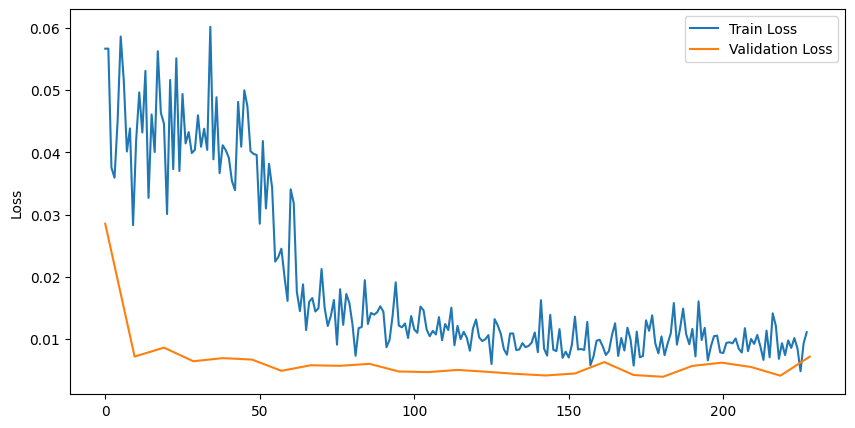

In [ ]:
# train, val loss hist 시각화

offset = 10

train_loss = model.train_losses[offset:]
val_loss = model.val_losses[offset:]
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
# val 길이를 train loss에 맞춰서 x축 조정
plt.plot(np.linspace(0, len(train_loss), len(val_loss)), val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

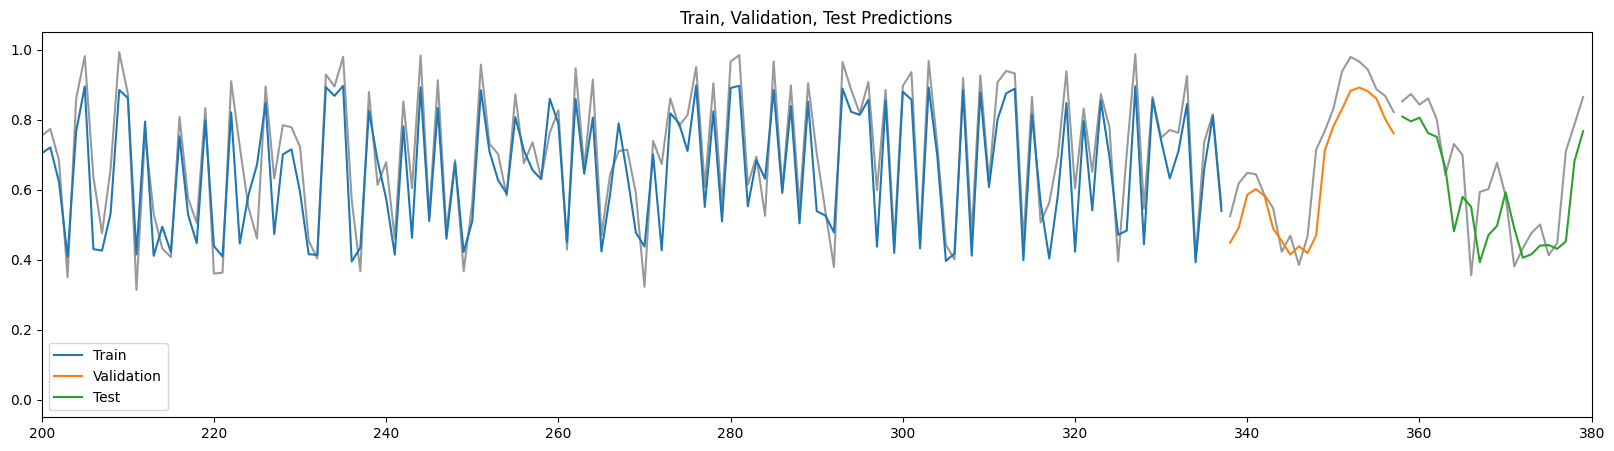

In [ ]:
model.eval()
predictions = []
targets = []

plt.figure(figsize=(20,5))

def plot_predictions(model, data_loader, start = 0,  concat = True, label = 'Train'):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for x, y in data_loader:
            pred = model(x)
            predictions.append(pred.cpu().squeeze().numpy())
            targets.append(y.cpu().squeeze().numpy())
    if concat:
        targets = np.concatenate(targets)
        predictions = np.concatenate(predictions)

    offset = start - input_window - output_window

    plt.plot(np.arange(offset, len(targets) + offset) , targets, c = 'grey', alpha = 0.8)
    plt.plot(np.arange(offset, len(targets) + offset) , predictions, label=label)

plot_predictions(model, train_loader)
plot_predictions(model, val_loader, start = len(train_loader.dataset), label = 'Validation')
plot_predictions(model, test_loader, start = len(train_loader.dataset) + len(val_loader.dataset), concat = False, label= 'Test')

plt.title('Train, Validation, Test Predictions')
x_max = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset) - input_window - output_window
plt.xlim(200,x_max)
plt.legend()
plt.show()
# 1- 철강 재료값 예측
# 2- 파도 높이 예측
# 3- 구내식당 사람 수 예측

# --> 시계열 이상 탐지 (수업에서 사용한 DATA로 이 모델이 적용하고 RNN과 비교해보세요)
# Deeplearning은 최적화가 핵심 --> k-fold Cross Validation,

In [ ]:
# RMSE, MAE, MAPE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predictions = []
targets = []

with torch.no_grad():
    for x, y in test_loader:
        pred = model(x)
        predictions.append(pred.cpu().squeeze().numpy())
        targets.append(y.cpu().squeeze().numpy())

targets = np.array(targets)
predictions = np.array(predictions)

test_rmse = rmse(targets, predictions)
test_mae = mae(targets, predictions)
test_mape = mape(targets, predictions)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f} %')
# scaler = MinMaxScaler() 눌려진 데이터가 복원되지 않아 평가치 다름

Test RMSE: 0.1234
Test MAE: 0.0990
Test MAPE: 16.3964 %
